# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

Load the environment app to run locally

In [2]:
env = UnityEnvironment(file_name='reacher_single.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Training the Agent

The Agent and replay Buffer are imported from the ddpg_agent.py file.
In order to train multiple agents via MADDPG, the memory is delocated from the individual agents and instantiated globaly.

The Parameters for the memory and agent were adjusted by trial and error and resulted in the implemented values.

Sadly, the multi-agent configuration was unable to use the GPU acceleration, making it impossible for me to run.

In [5]:
# Load the Agent from the ddpg_agent file
from ddpg_agent import Agent, ReplayBuffer
from collections import deque
import torch

import matplotlib.pyplot as plt
%matplotlib inline

# initialize the agent and the environment
#[Agent(state_size=state_size, action_size=action_size, random_seed=0, memory = memory, critic_target = critic_target) for count in range(num_agents)]

# Initialize agent and shared memory (for multi-agent use)
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
random_seed = 1

memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, memory = memory)



In [6]:
#training function
def ddpg(n_episodes=1000, max_t=1000, PRINT_EVERY=20):
    reached = False
    scores_deque = deque(maxlen=100)
    scores_hist = []
    max_score = -np.Inf
    eps = tnrange(1, n_episodes+1)                             # counter for episodes (for time eval)
    for i_episode in eps:
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        steps = tnrange(max_t, leave = False)                  # counter for steps (for time eval)
        for t in steps:
            steps.set_description("mean score is %f" % np.mean(scores_deque)) # write last score to counter
            #print(t)
            actions = agent.act(states)                        # calculate next action with actor net
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break
                
        score = np.mean(scores)                                # save scores for evaluation
        scores_deque.append(score)
        scores_hist.append(score)
        
        #steps.set_description("mean score is %f" % np.mean(scores_deque))
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % PRINT_EVERY == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if (np.mean(scores_deque) >= 31) and (reached == False):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            reached = True
            #break
        
    return scores_hist

In [7]:
# train the iteration of the agent and get scores
scores = ddpg()

/anaconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 20	Average Score: 1.12


Episode 40	Average Score: 2.08


Episode 60	Average Score: 3.43


Episode 80	Average Score: 5.93


Episode 100	Average Score: 8.75


Episode 120	Average Score: 13.16


Episode 140	Average Score: 18.52


Episode 160	Average Score: 24.21


Episode 180	Average Score: 28.49



Environment solved in 194 episodes!	Average Score: 31.02


Episode 200	Average Score: 31.71


Episode 220	Average Score: 34.26


Episode 240	Average Score: 35.72


Episode 260	Average Score: 36.41


Episode 280	Average Score: 37.10


Episode 300	Average Score: 37.28


Episode 320	Average Score: 37.84


Episode 340	Average Score: 38.13


Episode 360	Average Score: 38.19


Episode 380	Average Score: 38.32


Episode 400	Average Score: 38.71


Episode 420	Average Score: 38.79


Episode 440	Average Score: 38.88


Episode 460	Average Score: 39.04


Episode 480	Average Score: 39.04


Episode 500	Average Score: 39.01


Episode 520	Average Score: 38.98


Episode 540	Average Score: 38.86


Episode 560	Average Score: 38.81


Episode 580	Average Score: 38.84


Episode 600	Average Score: 38.81


Episode 620	Average Score: 38.73


Episode 640	Average Score: 38.63


Episode 660	Average Score: 38.40


Episode 680	Average Score: 38.40


Episode 700	Average Score: 37.77


Episode 720	Average Score: 37.64


Episode 740	Average Score: 37.86


Episode 760	Average Score: 38.12


Episode 780	Average Score: 37.96


Episode 800	Average Score: 38.47


Episode 820	Average Score: 38.55


Episode 840	Average Score: 38.43


Episode 860	Average Score: 38.29


Episode 880	Average Score: 38.32


Episode 900	Average Score: 38.28


Episode 920	Average Score: 38.32


Episode 940	Average Score: 38.34


Episode 960	Average Score: 38.50


Episode 980	Average Score: 38.57


Episode 1000	Average Score: 38.57



## Plot of Rewards

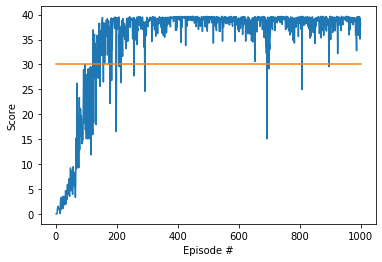

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(np.arange(1, len(scores)+1), scores)
sns.lineplot(x = np.arange(1, len(scores)+1), y = 30, data = data)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Aggregated Plot of Rewards

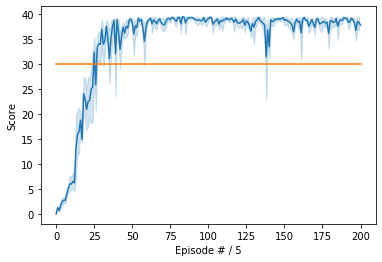

In [9]:
import pandas as pd
data = pd.DataFrame({"episode": np.arange(1, len(scores)+1), "scores" : scores})
data["episode_agg"] = data.episode // 5

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x="episode_agg", y="scores", data = data)
sns.lineplot(x = "episode_agg", y = 30, data = data)
plt.ylabel('Score')
plt.xlabel('Episode # / 5')
plt.show()

In [10]:
env.close()